# Checkpoint 1

### Importy

In [104]:
import pandas as pd
import numpy as np
import json
import ast

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import pickle

from utils import read_config
from pandas.io.json import json_normalize

plt.style.use('seaborn')

### Czytanie konfiguracji z pliku
Wczytywane są klucze do API YouTubowego, które nie powinny być udostępniane publicznie

In [105]:
config = read_config("config.json")
config['dataset_path'] = Path(config['dataset_path'])

### Porównanie plików zawierających kategorie


In [106]:
!diff data/GB_category_id.json data/US_category_id.json

3c3
<  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/1v2mrzYSYG6onNLt2qTj13hkQZk\"",
---
>  "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM\"",
161a162,171
>     "assignable": true
>    }
>   },
>   {
>    "kind": "youtube#videoCategory",
>    "etag": "\"m2yskBQFythfE4irbTIeOgYYfBU/SalkJoBWq_smSEqiAx_qyri6Wa8\"",
>    "id": "29",
>    "snippet": {
>     "channelId": "UCBR8-60-B28hp2BmDPdntcQ",
>     "title": "Nonprofits & Activism",


W pliku występują tylko dwie różnice: `etag`, który określa identyfikator zapytania. Jest to w naszym przypadku różnica, która nie ma znaczenia. Plik `data/US_category_id.json` zawiera za to o jedną kategorię więcej, niż brytyjski odpowiednik. Dodatkowa kategoria to `Nonprofits & Activism`. Ponieważ w pozostałych przypadkach pliki są jednakowe, to można użyć pliku `data/US_category_id.json` jako źródło informacji o kategoriach dla amerykańskich i brytyjskich kart trending.

# Wstępne statystyki

### Wczytywanie danych
Dane wczytywane są za pomocą biblioteki Pandas. Plik CSV jest odzielany za pomocą ';'. Dodatkowo przetwarzane są daty z tekstu na znaczniki czasowe. Kolumna `trending_date` nie może być automatycznie konwertowana, ponieważ posiada niestandardowy format daty: `rok.dzień.miesiąc` (odzielony kropkami, gdyby był odzielony ukośnikami `\`, to był by to standardowy format amerykański).

Ponieważ informacje o kategoriach są wspólne (jak było porównywane wcześniej) to obie tabele są łączone w jedną. Aby można odróżnić informację o źródle danych, dodana została kolumna `origin` zawierająca wartości `US` lub `GB`.

In [107]:
def load_csv(path, origin):
    df = pd.read_csv(path, sep=';', parse_dates=['publish_time'])
    df.columns = list(map(str.strip, df.columns))
    df['trending_date'] = pd.to_datetime(df.trending_date, format='%y.%d.%m')
    df['origin'] = origin
    return df


us_videos_df = load_csv(config['dataset_path'] / 'US_videos_5p.csv', 'US')
gb_videos_df = load_csv(config['dataset_path'] / 'GB_videos_5p.csv', 'GB')

videos_df = pd.concat([us_videos_df, gb_videos_df]).reset_index(drop=True)
# videos_df['origin'] = videos_df['origin'].astype('category')

# Pierwsze 3 i ostatnie 3 wartości
videos_df.iloc[[0,1,2,-3,-2,-1]]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US
79862,Il-an3K9pjg,2018-06-14,Anne-Marie - 2002 [Official Video],Anne-Marie,NaN,2018-05-08 11:05:08+00:00,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE ▶ http://ad.gt/200...,GB
79863,#NAZWA?,2018-06-14,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,NaN,2018-05-08 20:32:32+00:00,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB
79864,4YFo4bdMO8Q,2018-06-14,KYLE - Ikuyo feat. 2 Chainz & Sophia Black [A...,SuperDuperKyle,NaN,2018-05-11 04:06:35+00:00,"Kyle|""SuperDuperKyle""|""Ikuyo""|""2 Chainz""|""Soph...",607552,18271,274,1423,https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg,False,False,False,Debut album 'Light of Mine' out now: http://ky...,GB


### Podstawowe informacje o kolumnach

In [108]:
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79865 entries, 0 to 79864
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                79865 non-null  object             
 1   trending_date           79865 non-null  datetime64[ns]     
 2   title                   79865 non-null  object             
 3   channel_title           79865 non-null  object             
 4   category_id             3932 non-null   float64            
 5   publish_time            79865 non-null  datetime64[ns, UTC]
 6   tags                    79865 non-null  object             
 7   views                   79865 non-null  int64              
 8   likes                   79865 non-null  int64              
 9   dislikes                79865 non-null  int64              
 10  comment_count           79865 non-null  int64              
 11  thumbnail_link          79865 non-null  o

## Popsute ID filmów

### Zliczanie ID filmów

Zliczamy ID filmów aby sprawdzić, czy występują bardzo popularne filmy. Okazało się jednak, że najczęstrzym ID filmu jest `#NAZWA?`. Pozatym widać, że niektóre filmy są popularne przez wiele dni. Należy jednak sprawdzić, czy te same filmy nie są popularne w różnych krajach w tym samym dniu (liczone dwa razy).

In [109]:
videos_df.video_id.value_counts()

#NAZWA?        727
8h--kFui1JA     66
vjSohj-Iclc     62
l884wKofd54     61
VYOjWnS4cMY     61
              ... 
jGyUVyp9w9g      1
9wRQljFNDW8      1
9Pwy-cAf09I      1
QzfnWcHhdyQ      1
UYZ1WjJI1NM      1
Name: video_id, Length: 8511, dtype: int64

### Naprawianie zepsutych ID

Pobraliśmy dane za pomocą klasy `YTDownloader` z pliku `utils.py` a następnie zapisaliśmy je w formacie `pickle` do późniejszego wykorzystania. Aby pobrać unikalne ID filmu użyliśmy `Search YouTube API`, gdzie wyszukiwaliśmy filmy o konretnym tytule i od konretnego autora.

In [110]:
def load_missing_ids(path):
    with open(path, 'rb') as fh:
        return{k: v['items'][0]['id']['videoId'] for k, v in pickle.load(fh).items()}

us_missing = load_missing_ids(config['dataset_path'] / 'us_missing_id.pkl')
gb_missing = load_missing_ids(config['dataset_path'] / 'gb_missing_id.pkl')

for (title, channel), idx in {**us_missing, **gb_missing}.items():
    videos_df.loc[(videos_df.title == title) & (videos_df.channel_title == channel), 'video_id'] = idx

videos_df[videos_df.video_id == '#NAZWA?']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin


## Statystyki i wykresy

Rozkłady wartości odtworzeń, lików, dislików i komentarzy

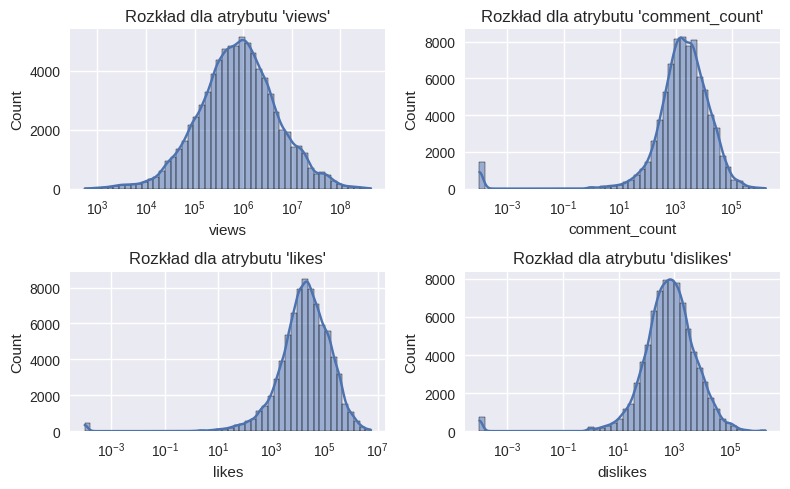

In [111]:
columns = np.array([['views', 'comment_count'], ['likes', 'dislikes']])
# Replace 0s for log scale
plot_df = videos_df[columns.ravel()].replace(0, 0.0001)
fig, ax = plt.subplots(2,2, figsize=(8,5), dpi=100) 

for xy, col in np.ndenumerate(columns):
    g = sns.histplot(plot_df, x=col, kde=True, log_scale=True, ax=ax[xy], bins=50)
    g.set(title=f'Rozkład dla atrybutu \'{col}\'')

fig.tight_layout()
plt.show()

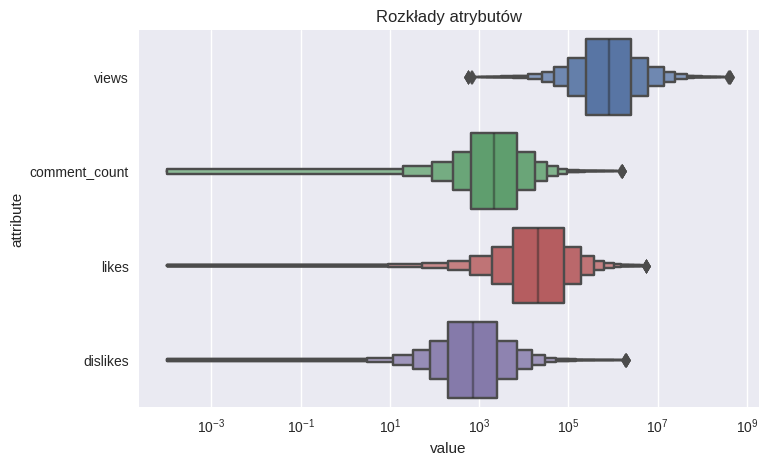

In [112]:
fig, ax = plt.subplots(figsize=(8,5), dpi=100)
g = sns.boxenplot(data=plot_df.melt(var_name='attribute'), x='value', y='attribute')
g.set(xscale='log', title="Rozkłady atrybutów")
plt.show()

Ilość różnych klas kategorii i równocześnie pokazanie niezbalansowania zbioru (przynajmniej przed wykorzystaniem metody semi-supervised learning)

In [113]:
# Read categories
with open(config['dataset_path'] / 'US_category_id.json', 'r') as f:
    us_categories = json.load(f)['items']

df_us_categories = pd.DataFrame(us_categories)
df_us_categories = df_us_categories.join(json_normalize(df_us_categories['snippet'].apply(lambda x: ast.literal_eval(str(x))).tolist()).add_prefix('snippet_'))
df_us_categories.drop(columns=['snippet', 'kind', 'etag', 'snippet_channelId', 'snippet_assignable'], inplace=True)
df_us_categories['id'] = df_us_categories['id'].astype('float64')
df_us_categories.rename(columns={'snippet_title': 'category_text'}, inplace=True)

df_us_categories

<ipython-input-113-c4b28831c080>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_us_categories = df_us_categories.join(json_normalize(df_us_categories['snippet'].apply(lambda x: ast.literal_eval(str(x))).tolist()).add_prefix('snippet_'))


,id,category_text
0,1.0,Film & Animation
1,2.0,Autos & Vehicles
2,10.0,Music
3,15.0,Pets & Animals
4,17.0,Sports
5,18.0,Short Movies
6,19.0,Travel & Events
7,20.0,Gaming
8,21.0,Videoblogging
9,22.0,People & Blogs


In [114]:
# Join data information
videos_df_merged = videos_df.merge(df_us_categories, left_on='category_id', right_on='id', how='left')
videos_df_merged.drop(columns=['id'], inplace=True)
videos_df_merged.iloc[[0,1,2,-3,-2,-1]]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,origin,category_text
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13 17:13:01+00:00,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US,NaN
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,NaN,2017-11-13 07:30:00+00:00,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",US,NaN
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,NaN,2017-11-12 19:05:24+00:00,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,US,NaN
79862,Il-an3K9pjg,2018-06-14,Anne-Marie - 2002 [Official Video],Anne-Marie,NaN,2018-05-08 11:05:08+00:00,"anne|""marie""|""anne-marie""|""2002""|""two thousand...",29641412,394830,8892,19988,https://i.ytimg.com/vi/Il-an3K9pjg/default.jpg,False,False,False,Get 2002 by Anne-Marie HERE ▶ http://ad.gt/200...,GB,NaN
79863,eDSgs6syrgg,2018-06-14,Eleni Foureira - Fuego - Cyprus - LIVE - First...,Eurovision Song Contest,NaN,2018-05-08 20:32:32+00:00,"Eurovision Song Contest|""2018""|""Lisbon""|""Cypru...",14317515,151870,45875,26766,https://i.ytimg.com/vi/-DRsfNObKIQ/default.jpg,False,False,False,Eleni Foureira represented Cyprus at the first...,GB,NaN
79864,4YFo4bdMO8Q,2018-06-14,KYLE - Ikuyo feat. 2 Chainz & Sophia Black [A...,SuperDuperKyle,NaN,2018-05-11 04:06:35+00:00,"Kyle|""SuperDuperKyle""|""Ikuyo""|""2 Chainz""|""Soph...",607552,18271,274,1423,https://i.ytimg.com/vi/4YFo4bdMO8Q/default.jpg,False,False,False,Debut album 'Light of Mine' out now: http://ky...,GB,NaN


<AxesSubplot:xlabel='count', ylabel='category_text'>

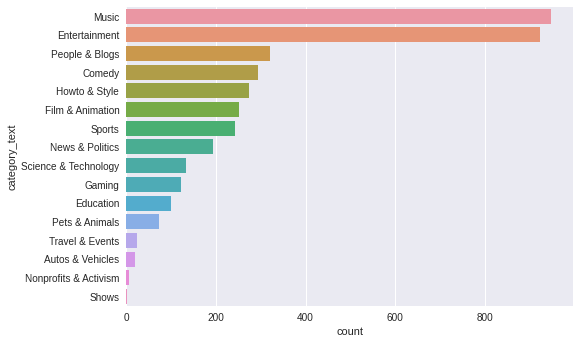

In [115]:
# Plot results
sns.countplot(data=videos_df_merged, y="category_text", order=videos_df_merged["category_text"].value_counts().index)

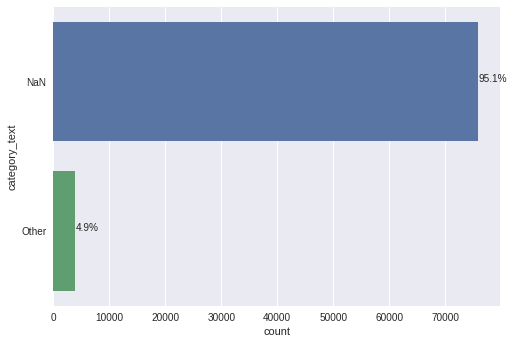

In [116]:
videos_df_merged_temp = videos_df_merged.fillna('NaN')
videos_df_merged_temp.loc[videos_df_merged_temp["category_text"] != 'NaN', "category_text"] = 'Other'
ax = sns.countplot(data=videos_df_merged_temp, y="category_text", order = videos_df_merged_temp["category_text"].value_counts().index)
# Add percentage
total = len(videos_df_merged_temp['category_text'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

# Inżynieria cech tekstowych

In [117]:
text_features = ['title', 'description', 'channel_title']


### Shouting Ratio
Określa stosunek dużych liter do wszystkich liter

In [118]:
def shouting_ratio(text):
  """Returns ratio of upper letters to all letters. Ignores non-letters in summary"""
  if not isinstance(text, str):
    return np.nan

  letters = ''.join(filter(str.isalpha, text))
  if letters:
    uppers = ''.join(filter(str.isupper, letters))
    return len(uppers) / len(letters)
  else:
    return 0

shouting_df = videos_df[text_features].applymap(shouting_ratio)
pd.concat([shouting_df.head(), videos_df[text_features].head()], axis=1)

,title,description,channel_title,title,description,channel_title
0,1.000000,0.237321,0.166667,WE WANT TO TALK ABOUT OUR MARRIAGE,SHANTELL'S CHANNEL - https://www.youtube.com/s...,CaseyNeistat
1,0.220000,0.068000,0.200000,The Trump Presidency: Last Week Tonight with J...,"One year after the presidential election, John...",LastWeekTonight
2,0.195122,0.166464,0.181818,"Racist Superman | Rudy Mancuso, King Bach & Le...",WATCH MY PREVIOUS VIDEO ▶ SUBSCRIBE ► https:/...,Rudy Mancuso
3,0.153846,0.087079,0.157895,Nickelback Lyrics: Real or Fake?,Today we find out if Link is a Nickelback amat...,Good Mythical Morning
4,0.705882,0.051724,0.000000,I Dare You: GOING BALD!?,I know it's been a while since we did this sho...,nigahiga


Rozkłady cech Shouting ratio

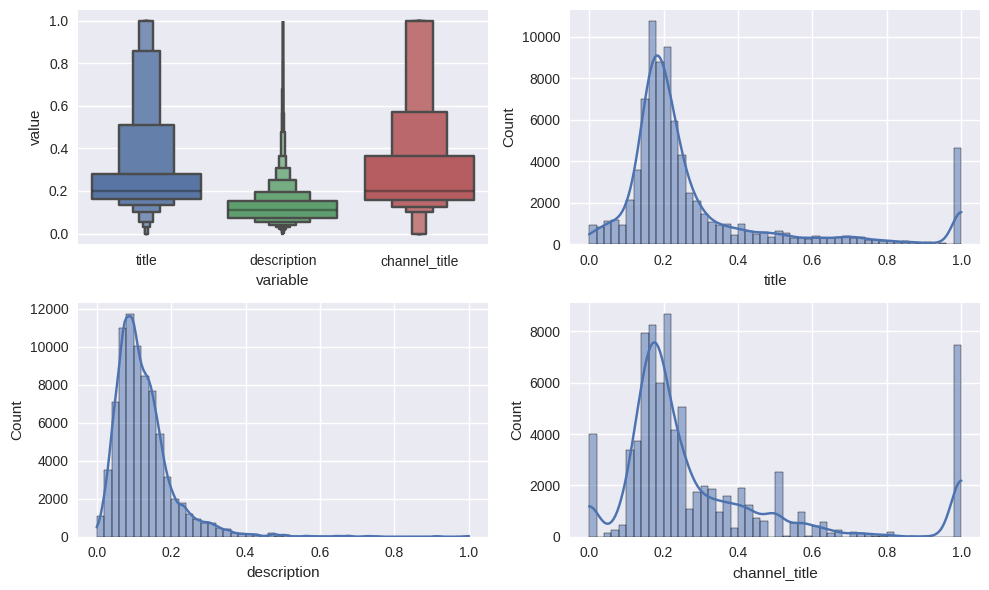

In [119]:
fig, ax = plt.subplots(2,2, figsize=(10,6), dpi=100)
g = sns.boxenplot(data=shouting_df.melt(), x='variable', y='value', ax=ax[0,0])
g = sns.histplot(data=shouting_df[text_features[0]], ax=ax[0,1], kde=True, bins=50)
g = sns.histplot(data=shouting_df[text_features[1]], ax=ax[1,0], kde=True, bins=50)
g = sns.histplot(data=shouting_df[text_features[2]], ax=ax[1,1], kde=True, bins=50)

fig.tight_layout()
plt.show()

Niektóre tytuły, opisy i nazwy kanałów o współczyniku shouting ratio > 0.95 

In [120]:
def shouting_gt95(col):
    print(col)
    return videos_df[shouting_df[col] > 0.95][col].value_counts()

In [121]:
shouting_gt95(text_features[0])

title


MY PARENTS DO MY MAKEUP                                               46
NOTHING BEATS A LONDONER                                              43
ADULTS REACT TO KARMA IS A BITCH CHALLENGE                            41
CRISTIANO RONALDO E FRED, O GRANDE ENCONTRO                           39
WINNER - ‘EVERYDAY’ M/V                                               39
                                                                      ..
KYLIE COSMETICS X KRIS JENNER COLECTION | SWATCHES & DEMO              1
COME SHOPPING WITH ME AND TRY ON NEW CLOTHING FOR AUTUMN | VLOG 49     1
CHRISTMAS HAS GONE TO MY HEAD                                          1
HER FIRST STEPS! INDIE THE EWOK & THE BEST FACIAL | VLOG               1
YOU LAUGH YOU SOY                                                      1
Name: title, Length: 493, dtype: int64

In [122]:
shouting_gt95(text_features[1])

description


ENGLAND V BELGIUM - WORLD CUP 1990 - DAVID PLATT'S  GOAL - 26TH JUNE - BOLGNA, ITALY. IN THE LAST MINUTE OF EXTRA TIME ENGLAND'S DAVID PLATT SCORES WITH A FANTASTIC VOLLEY ON THE TURN FROM PAUL GASCOIGNE'S FREE KICK. A BRILLIANT GOAL IN  A VERY IMPORTANT GAME.    11
BUYING HER OWN ALBUM IN TARGET                                                                                                                                                                                                                                           6
SKOL! SKOL! SKOL!                                                                                                                                                                                                                                                        6
OH BOY                                                                                                                                                                                                 

Widać, że nazwa kanału nie powinna być brana jako 'krzyk' ponieważ dużo nazw kanałów to są skróty nazw włąsnych np.: CNN itp.

In [123]:
shouting_gt95(text_features[2])

channel_title


WWE             362
ESPN            334
WIRED           305
CNN             305
SMTOWN          250
               ... 
WE2LITCREW        1
SHOWTIME          1
M2                1
UMF TV            1
CIRCUITBEARD      1
Name: channel_title, Length: 220, dtype: int64

### Proste cechy
Liczba znaków zapytania, liczba wykrzykników, liczba liter i cyfr, liczba linków, liczba dolarów, liczba hashtagów.

Dostępne znaki:


In [124]:
import string
' '.join(list(string.punctuation))

'! " # $ % & \' ( ) * + , - . / : ; < = > ? @ [ \\ ] ^ _ ` { | } ~'

Symbole często wykorzystywane do wzbucenia zainteresowania:

In [125]:
attention_symbols = '!?$#'

#### Liczba znaków specjalnych

In [126]:
def plot_text_features_distributions(df, features=None, log=False):
    if features is None:
        features = text_features
    
    fig, ax = plt.subplots(2,2, figsize=(10,6), dpi=100)
    g = sns.boxenplot(data=df.melt(), x='variable', y='value', ax=ax[0,0])
    g = sns.histplot(data=df[features[0]] + (0.000000001 if log else 0), ax=ax[0,1], kde=True, bins=50, log_scale=log)
    g = sns.histplot(data=df[features[1]] + (0.000000001 if log else 0), ax=ax[1,0], kde=True, bins=50, log_scale=log)
    g = sns.histplot(data=df[features[2]] + (0.000000001 if log else 0), ax=ax[1,1], kde=True, bins=50, log_scale=log)

    fig.tight_layout()
    plt.show()

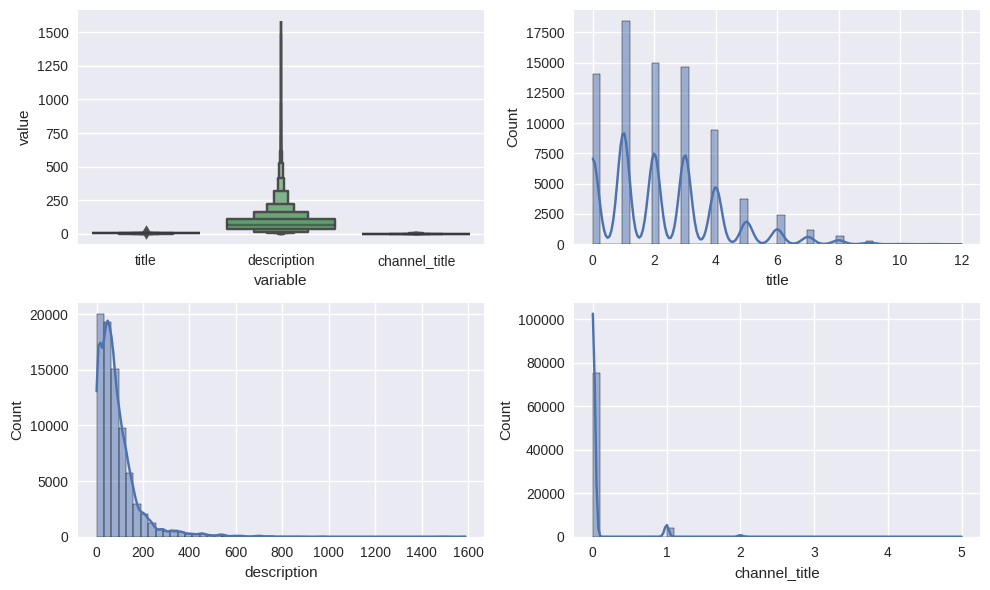

In [127]:
def punctutation_count(text):
    return len([c for c in str(text) if c in string.punctuation])

punctutation_count_df = videos_df[text_features].applymap(punctutation_count)
videos_df[[n+'_punctuation_count' for n in text_features]] = punctutation_count_df
plot_text_features_distributions(punctutation_count_df)

#### Liczba znaków atencji

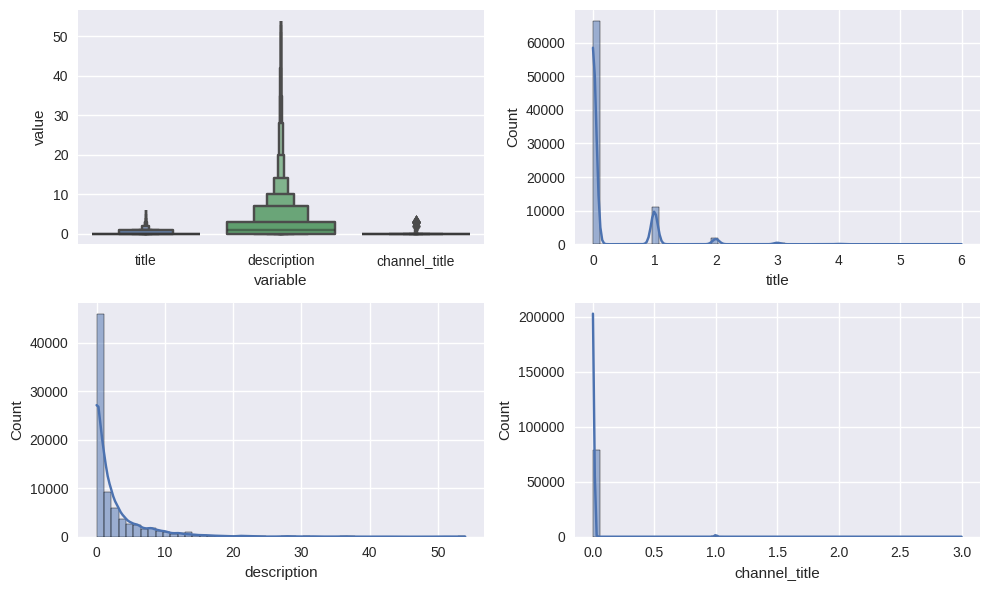

In [128]:
def attention_count(text):
    return len([c for c in str(text) if c in attention_symbols])

attention_count_df = videos_df[text_features].applymap(attention_count)
videos_df[[n+'_attention_count' for n in text_features]] = attention_count_df
plot_text_features_distributions(attention_count_df)

#### Długość tekstu

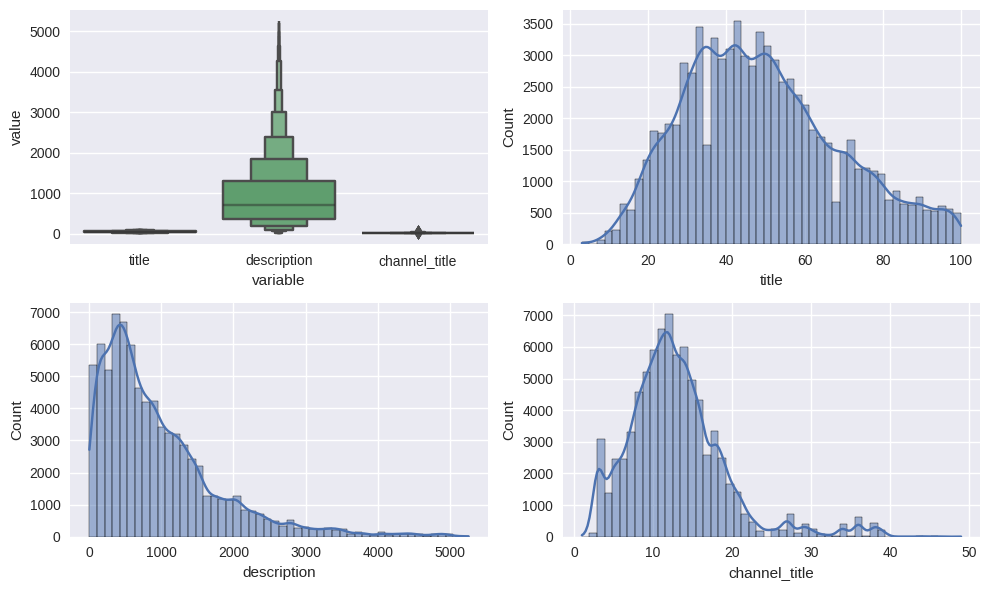

In [129]:
def text_len(text):
    return len(str(text))

text_len_df = videos_df[text_features].applymap(text_len)
videos_df[[n+'_len' for n in text_features]] = text_len_df
plot_text_features_distributions(text_len_df)

#### Długość tekstu

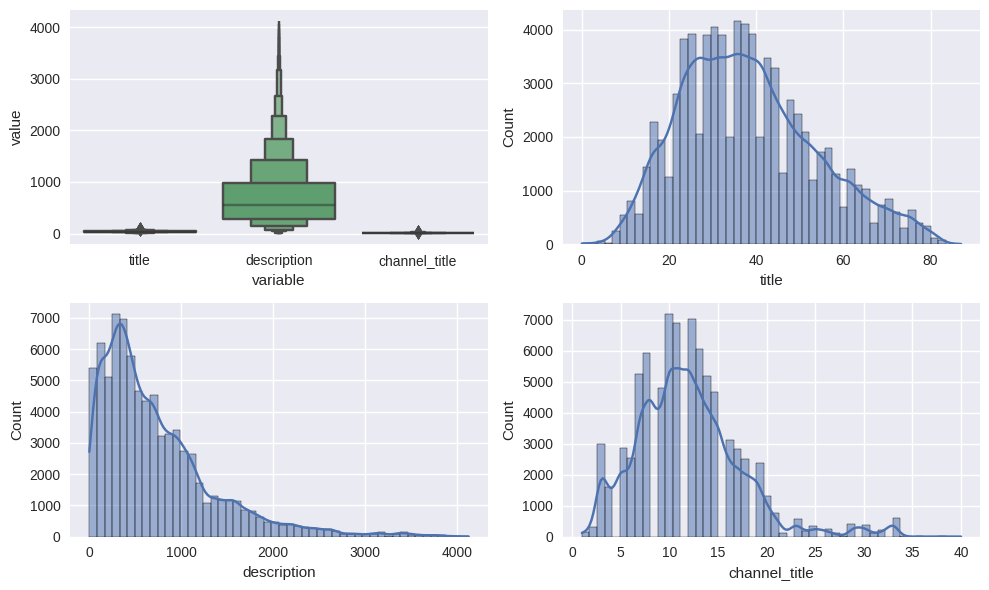

In [130]:
def letter_count(text):
    return len(list(filter(str.isalpha, str(text))))

letter_count_df = videos_df[text_features].applymap(letter_count)
videos_df[[n+'_letter_count' for n in text_features]] = letter_count_df
plot_text_features_distributions(letter_count_df)

#### Stosunek liter do wszystkich znaków - poziom informatywności

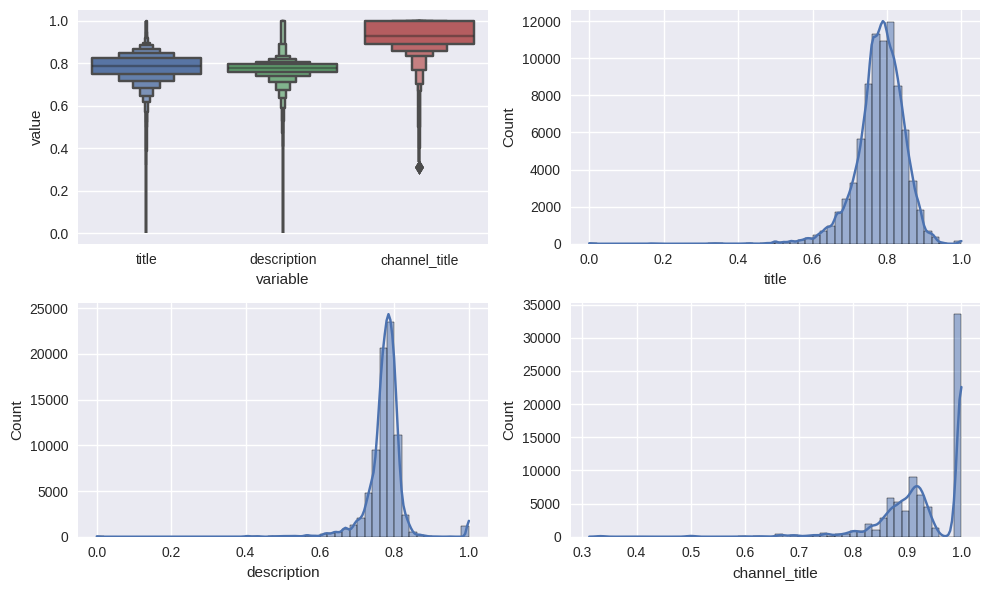

In [131]:
def information_ratio(df):
    for name in text_features:
        df[name+'_information_ratio'] = (df[name+'_letter_count'] / df[name+'_len']).fillna(0)
    return df

information_ratio_names = [n+'_information_ratio' for n in text_features]
videos_df = information_ratio(videos_df)
plot_text_features_distributions(videos_df[information_ratio_names].rename(lambda n: n.split('_information')[0], axis=1))

Opisy o małej najmniejszej zawartości informacyjnej. Widać że występują filmy, które posiadają jedynie kropki w opisie filmy lub w ogóle nie mają opisu.

In [132]:
videos_df[['title', 'description', 'description_information_ratio']].sort_values('description_information_ratio').head(10)

,title,description,description_information_ratio
12740,The Cranberries - Dreams (Music Video HQ),,0.0
11102,notting-hill-movie-clip-last-brownie,,0.0
53859,Regarding the rumors about me today,.,0.0
53626,Regarding the rumors about me today,.,0.0
54939,Regarding the rumors about me today,.,0.0
52553,Regarding the rumors about me today,.,0.0
53396,Regarding the rumors about me today,.,0.0
44435,Roberto Carlos vs France 1997,,0.0
54502,Regarding the rumors about me today,.,0.0
11328,notting-hill-movie-clip-last-brownie,,0.0


Opisy o małej najmniejszej zawartości informacyjnej pomiędzy 0.1, a 0.2


#### Stosunek znaków atencji do wszystkich liter

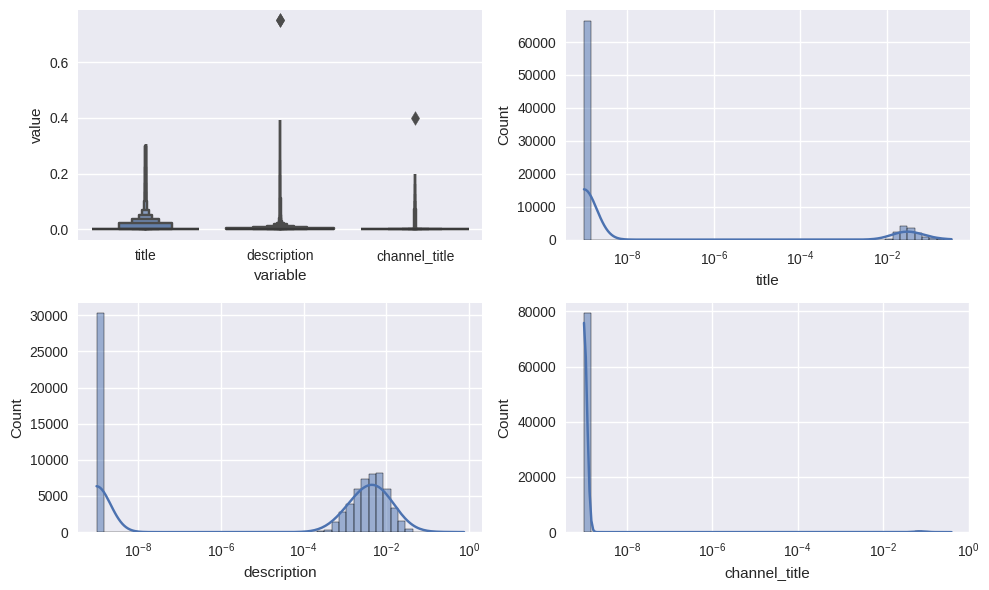

In [133]:
def attention_ratio(df):
    for name in text_features:
        df[name+'_attention_ratio'] = (df[name+'_attention_count'] / df[name+'_letter_count']).fillna(0)
    return df

attention_ratio_names = [n+'_attention_ratio' for n in text_features]
videos_df = attention_ratio(videos_df)
plot_text_features_distributions(videos_df[attention_ratio_names].rename(lambda n: n.split('_attention')[0], axis=1), log=True)

Można zobaczyć, że występują filmy o bardzo dużym współczyniku atencji w opisie, zawierają ogromną liczbę wykrzykników lub hashtagów

In [134]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'description', 'description_attention_ratio']]. \
    sort_values('description_attention_ratio', ascending=False)

,title,description,description_attention_ratio
52098,Omae wa mo shinderu | The Last Jedi edition,Nani!!?,0.750000
44155,Jesse Lingard's INSANE solo Goal vs Watford,Jesse Lingard 4-2 !!!!!!!!!!!\n\nINSANE solo Goal,0.392857
12218,Saints vs Vikings 2018 (Minnesota Vikings Mir...,SKOL! SKOL! SKOL!,0.250000
49946,[SPECIAL VIDEO] NU'EST W(뉴이스트W) & SEVENTEEN(세븐...,#플레디스 #뉴이스트W #세븐틴 #HEAVEN,0.222222
45170,Zion.T – '눈(SNOW) (feat.이문세)' M/V,#ZIONT #자이언티 #with #LEEMOONSAE #이문세 #AHNJAEHON...,0.194030
...,...,...,...
18586,Watch Rosenstein’s full announcement of the in...,Deputy Attorney General Rod J. Rosenstein on F...,0.000000
18588,"Meet Nathan Chen, the Figure Skater Who Brough...",Nathan Chen is 18 and the United States' best ...,0.000000
18593,Demi Lovato - Tell Me You Love Me (Acoustic),Demi Lovato Tell Me You Love Me DELUXE: https:...,0.000000
18595,Mic'd up: Listen to Mikaela Shiffrin's gold me...,A nearly unfiltered and behind-the-scenes look...,0.000000


Można zobaczyć, że występują filmy o bardzo dużym współczyniku atencji w tytule, zawierają ogromną liczbę wykrzykników lub hashtagów. Co ciekawe filmy które dostały się na kartę Trendy, nie posiadają gigantycznej liczby wykrzykników lub znaków zapytania w tytule. Może to oznaczać, że tworzenie "clickbaitowych" wymaga pewnego przemyślenia, a nie dodawania dużej liczby wykrzykników.

In [135]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'title_attention_ratio']].sort_values('title_attention_ratio', ascending=False)

,title,title_attention_ratio
75578,#Laurel? #Yanny? Or...,0.307692
15991,"😱 $1,145 iPhone Case!!",0.300000
19620,WTF - $300 Toaster?!,0.300000
13565,생후 60일 된 새끼가 사라졌다!!?,0.272727
38955,"$40 Gym Vs. $10,000 Gym",0.250000
...,...,...
14242,BTS Takes on L.A. | Vogue,0.000000
14237,Brad Makes Sous Vide Steak | Kitchen Basics | ...,0.000000
14236,Judge Aquilina Delivers Powerful Statement Bef...,0.000000
14235,People Try The New Diet Coke Flavors,0.000000


#### Liczenie słów

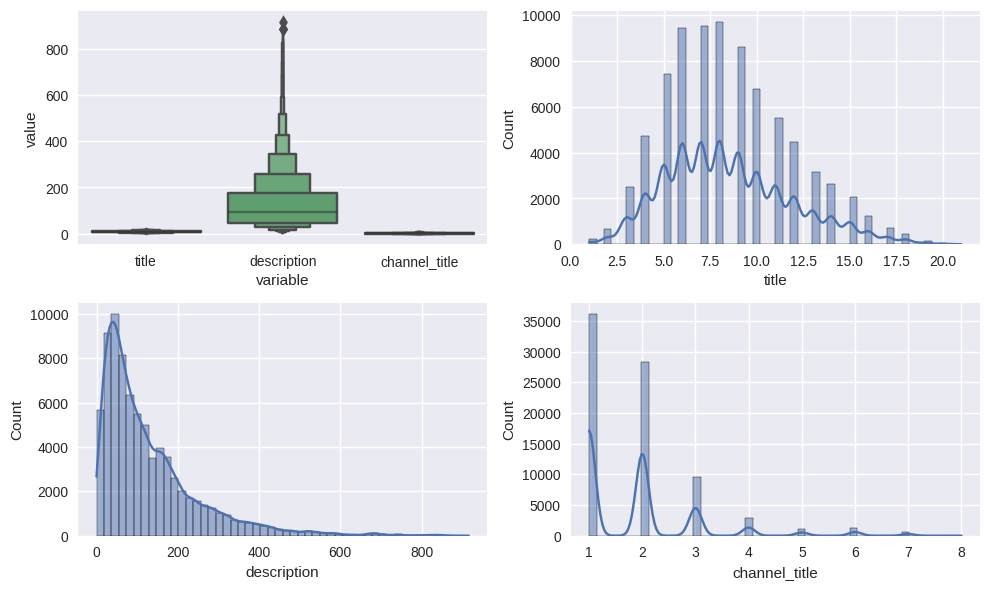

In [151]:
def word_count(df):
    for name in text_features:
        df[name+'_word_count'] = df[name].str.count(r"[\w\-_#\/\\\+\:$?]+")
    return df

word_count_names = [name+'_word_count' for name in text_features]
videos_df = word_count(videos_df)
plot_text_features_distributions(videos_df[word_count_names].rename(lambda n: n.split('_word')[0], axis=1))

#### Liczenie hiperlinków w opisie

<AxesSubplot:xlabel='description_url_count', ylabel='Count'>

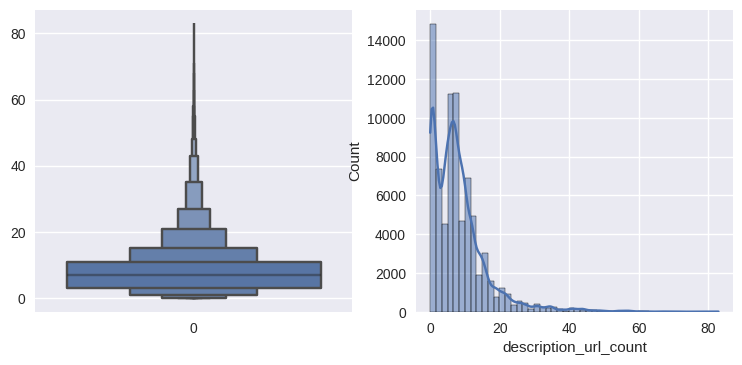

In [156]:
def url_count(df):
    df['description_url_count'] = df.description.str.count(r"(https?:\/\/)?(\w+\.\w+)[\?=\&\w_\-.\/.]*")
    return df

videos_df = url_count(videos_df)
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.boxenplot(data=videos_df.description_url_count, ax=ax[0])
sns.histplot(data=videos_df.description_url_count, kde=True, bins=50, ax=ax[1])

#### Stosunek hiperlinków do słów w opisie

<AxesSubplot:xlabel='description_url_ratio', ylabel='Count'>

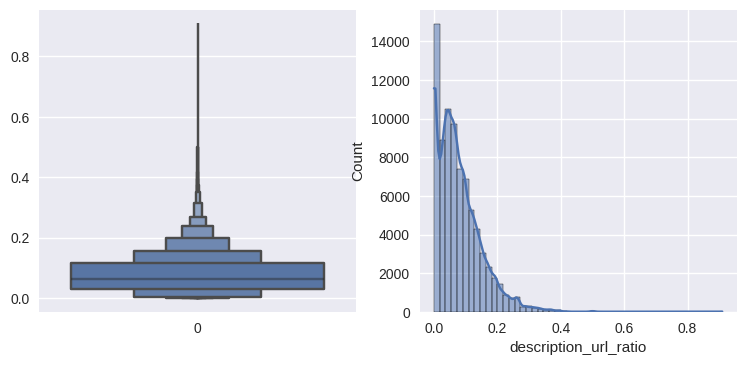

In [157]:
def url_ratio(df):
    df['description_url_ratio'] = (df['description_url_count'] / df['description_word_count']).fillna(0)
    return df

videos_df = url_ratio(videos_df)
fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=100)
sns.boxenplot(data=videos_df.description_url_ratio, ax=ax[0])
sns.histplot(data=videos_df.description_url_ratio, kde=True, bins=50, ax=ax[1])

In [158]:
videos_df.drop_duplicates(subset=['video_id'])[['title', 'description', 'description_url_ratio']].sort_values('description_url_ratio', ascending=False)

,title,description,description_url_ratio
4935,It's Here!!! CASEY NEISTAT MERCH,https://shopcaseyneistat.com https://shopcasey...,0.500000
14273,China BANS Hip Hop From Television,http://time.com/5112061/china-hip-hop-ban-tatt...,0.500000
5490,exixe clock in action,https://github.com/dekuNukem/exixe https://git...,0.500000
69173,YOU GROOVE YOU LOSE,SUBMIT MEMES: https://www.reddit.com/r/Pewdiep...,0.395349
66892,GREENTEXT MEMES,SUBMIT MEMES: https://www.reddit.com/r/Pewdiep...,0.395349
...,...,...,...
7898,FLOYD MAYWEATHER KILLS UFC TALK; DENIES DANA W...,That's not what I said....exactly what I said ...,0.000000
7933,Jonghyun Lonely (Feat. 태연) - Piano Cover,Jonghyun is the best artist who loved music mo...,0.000000
7984,Christian Bale: Division Is Not The Way To Go,The actor says our culture will be richer when...,0.000000
45170,Zion.T – '눈(SNOW) (feat.이문세)' M/V,#ZIONT #자이언티 #with #LEEMOONSAE #이문세 #AHNJAEHON...,0.000000
